In [1]:
import pickle
import pandas as pd
import sklearn
import numpy as np
import scanpy as sc
import scipy.sparse
import anndata
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
import copy
import logging as logg
from sklearn import preprocessing
import os 
import warnings
import scATAcat
import seaborn as sns
import random as rn 

warnings.filterwarnings('ignore')

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


#### define necessary parameters

In [3]:
results_dir = "../../../results/Supplementary_tables/ST4-10X_PBMC_scmultiome_accuracy_acros_clustering_res/"
output_dir = results_dir+"res0.2/outputs/"
figures_dir = results_dir+"res0.2/figures/"
data_dir = "../../../data/"

for dir in [figures_dir, output_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)


In [4]:
leiden_resolution=0.2
leiden_key="leiden_"+ str(leiden_resolution)

### 0 - Load scATAC-seq data

In [5]:
ENCODE_coverage_per_cell_df= pickle.load(open(data_dir + '10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/PBMC_ENCODE_coverage_per_cell_matrix_sparse.pkl','rb'))


In [6]:
ENCODE_coverage_per_cell_df

<926535x10411 sparse matrix of type '<class 'numpy.float32'>'
	with 123604223 stored elements in Compressed Sparse Row format>

In [7]:
ENCODE_cCREs = pd.read_csv(data_dir +"10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/ENCODE_coverage_per_cell_ENCODE_cCREs.csv", index_col=0)
ENCODE_cCREs.columns = ["cCREs"]
ENCODE_cCREs.index = ENCODE_cCREs['cCREs']
ENCODE_cCREs.head()

,cCREs
cCREs,
chr1_181251_181601,chr1_181251_181601
chr1_190865_191071,chr1_190865_191071
chr1_778562_778912,chr1_778562_778912
chr1_779086_779355,chr1_779086_779355
chr1_779727_780060,chr1_779727_780060


In [8]:
cell_IDs = pd.read_csv(data_dir +"10X_PBMC_scmultiome/02_ENCODE_coverage_by_cell_matrix/ENCODE_coverage_per_cell_cell_IDs.csv", index_col=0)
cell_IDs.columns = ["cell_IDs"]
cell_IDs.index = cell_IDs["cell_IDs"]
cell_IDs.head()

,cell_IDs
cell_IDs,
AAACAGCCAATCCCTT-1,AAACAGCCAATCCCTT-1
AAACAGCCAATGCGCT-1,AAACAGCCAATGCGCT-1
AAACAGCCACCAACCG-1,AAACAGCCACCAACCG-1
AAACAGCCAGGATAAC-1,AAACAGCCAGGATAAC-1
AAACAGCCAGTAGGTG-1,AAACAGCCAGTAGGTG-1


### 1 - initialize the AnnData object

In [9]:
sc_completeFeatures_adata = anndata.AnnData(ENCODE_coverage_per_cell_df.transpose(), var=ENCODE_cCREs, obs=cell_IDs)


In [10]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'

### 2 - add binary layer to AnnData

In [11]:
scATAcat.add_binary_layer(sc_completeFeatures_adata, binary_layer_key="binary")

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    layers: 'binary'

## 3- calculate & plot cell and feature statistics

In [12]:
scATAcat.cell_feature_statistics(sc_completeFeatures_adata, binary_layer_key ='binary')

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

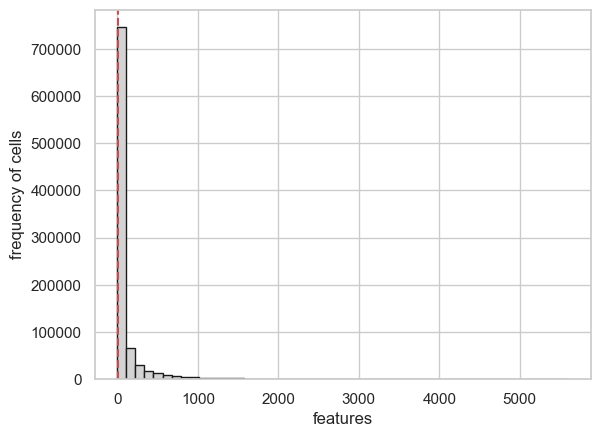

In [13]:
scATAcat.plot_feature_statistics(sc_completeFeatures_adata, threshold=3, bins=50, color="lightgrey", save=True, save_dir = figures_dir +"/feature_statistics_plot.png")

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

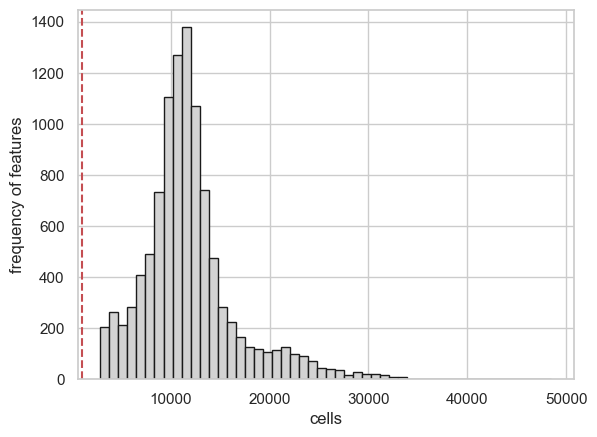

In [14]:
scATAcat.plot_cell_statistics(sc_completeFeatures_adata, threshold=1000, bins=50, color="lightgrey", save=True, save_dir = figures_dir + "/cell_statistics_plot.png")

## 4- filter the cells and features

In [15]:
sc_completeFeatures_adata

AnnData object with n_obs × n_vars = 10411 × 926535
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

In [16]:
sc_filteredFeatures_adata = scATAcat.preproces_sc_matrix(sc_completeFeatures_adata,cell_cutoff=1000,cell_cutoff_max=80000, feature_cutoff=3, remove_chrY = True, var_key = 'cCREs', copy=True)

In [17]:
sc_filteredFeatures_adata

View of AnnData object with n_obs × n_vars = 10411 × 742148
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

#### note that here we filtered almost half of the features!

### 5- load & preprocess the bulk data

In [18]:
bulk_by_ENCODE_peaks_df_annotated =  pickle.load(open(data_dir + "Corces2016_bulk_ATAC/02_ENCODE_coverage_by_prototypes_matrix/Corces2016bulkATAC_ENCODE_cCRE_overlappingPeaks_annotated.pkl", 'rb'))
bulk_by_ENCODE_peaks_df_annotated = bulk_by_ENCODE_peaks_df_annotated.reindex(sorted(bulk_by_ENCODE_peaks_df_annotated.columns), axis=1)

In [19]:
bulk_by_ENCODE_peaks_df_annotated.columns

Index(['Bcell_1', 'Bcell_2', 'Bcell_3', 'Bcell_4', 'CD34_Bone_Marrow_1',
       'CD34_Bone_Marrow_2', 'CD34_Cord_Blood_1', 'CD4Tcell_1', 'CD4Tcell_2',
       'CD4Tcell_3', 'CD4Tcell_4', 'CD4Tcell_5', 'CD8Tcell_1', 'CD8Tcell_2',
       'CD8Tcell_3', 'CD8Tcell_4', 'CD8Tcell_5', 'CLP_1', 'CLP_2', 'CLP_3',
       'CLP_4', 'CLP_5', 'CMP_1', 'CMP_2', 'CMP_3', 'CMP_4', 'CMP_5', 'CMP_6',
       'CMP_7', 'CMP_8', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6',
       'Ery_7', 'Ery_8', 'GMP_1', 'GMP_2', 'GMP_3', 'GMP_4', 'GMP_5', 'GMP_6',
       'GMP_7', 'HSC_1', 'HSC_2', 'HSC_3', 'HSC_4', 'HSC_5', 'HSC_6', 'HSC_7',
       'LMPP_1', 'LMPP_2', 'LMPP_3', 'MEP_1', 'MEP_2', 'MEP_3', 'MEP_4',
       'MEP_5', 'MEP_6', 'MEP_7', 'MPP_1', 'MPP_2', 'MPP_3', 'MPP_4', 'MPP_5',
       'MPP_6', 'Mono_1', 'Mono_2', 'Mono_3', 'Mono_4', 'Mono_5', 'Mono_6',
       'NKcell_1', 'NKcell_2', 'NKcell_3', 'NKcell_4', 'NKcell_5', 'NKcell_6'],
      dtype='object')

In [20]:
#subset for terminal cell states
bulk_by_ENCODE_peaks_df_annotated
bulk_by_ENCODE_peaks_df_annotated= bulk_by_ENCODE_peaks_df_annotated[['Bcell_1', 'Bcell_2', 'Bcell_3', 'Bcell_4', 'CD4Tcell_1',
       'CD4Tcell_2', 'CD4Tcell_3', 'CD4Tcell_4', 'CD4Tcell_5',
       'CD8Tcell_1', 'CD8Tcell_2', 'CD8Tcell_3', 'CD8Tcell_4',
       'CD8Tcell_5', 'Mono_1', 'Mono_2', 'Mono_3', 'Mono_4', 'Mono_5',
       'Mono_6', 'NKcell_1', 'NKcell_2', 'NKcell_3', 'NKcell_4',
       'NKcell_5', 'NKcell_6']]

In [21]:
# include pDCs
pDCs = pickle.load(open(data_dir + 'Corces2016_bulk_ATAC/02_ENCODE_coverage_by_prototypes_matrix/Calderon2019_pDC_ENCODE_cCRE_overlappingPeaks_annotated.pkl', 'rb'))
pDCs.head()

,pDC_1,pDC_2,pDC_3
chr1_181251_181601,4,15,26
chr1_190865_191071,0,0,0
chr1_778562_778912,91,373,165
chr1_779086_779355,17,37,28
chr1_779727_780060,6,7,11


In [22]:
bulk_by_ENCODE_peaks_df_annotated = pd.concat([bulk_by_ENCODE_peaks_df_annotated, pDCs.loc[bulk_by_ENCODE_peaks_df_annotated.index,:]], axis=1 )

In [23]:
bulk_by_ENCODE_peaks_df_annotated.head()

,Bcell_1,Bcell_2,Bcell_3,Bcell_4,CD4Tcell_1,CD4Tcell_2,CD4Tcell_3,CD4Tcell_4,CD4Tcell_5,CD8Tcell_1,...,Mono_6,NKcell_1,NKcell_2,NKcell_3,NKcell_4,NKcell_5,NKcell_6,pDC_1,pDC_2,pDC_3
chr1_181251_181601,6,9,9,0,4,6,6,6,5,2,...,8,3,3,4,17,2,6,4,15,26
chr1_190865_191071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
chr1_778562_778912,59,319,518,183,210,271,242,458,349,84,...,155,163,146,115,529,262,322,91,373,165
chr1_779086_779355,21,40,85,35,33,42,42,80,35,13,...,25,40,22,21,95,34,36,17,37,28
chr1_779727_780060,2,13,8,2,1,9,6,2,2,0,...,1,5,2,3,8,5,0,6,7,11


In [24]:
bulk_completeFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(bulk_by_ENCODE_peaks_df_annotated)

In [25]:
bulk_completeFeatures_adata

AnnData object with n_obs × n_vars = 29 × 926535
    obs: 'cell_types'
    var: 'cCREs'

In [26]:
bulk_completeFeatures_adata = scATAcat.preprocess_bulk_adata(bulk_completeFeatures_adata, remove_chrY=True, var_key = 'cCREs', copy=False)

### 6 - Overlap bulk and sc features

- before we proceed with sc analysis, we need to overlap the features:
    - we don't want the feature that does not have any counts in bulk data to influence clustering
    - similarly, we want the projection to be defined only with the same feature set

In [27]:
sc_bulk_common_vars = scATAcat.overlap_vars(sc_filteredFeatures_adata, bulk_completeFeatures_adata)

In [28]:
len(sc_bulk_common_vars)

742116

In [29]:
sc_commonFeatures_adata = scATAcat.subset_adata_vars(sc_filteredFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


In [30]:
bulk_commonFeatures_adata = scATAcat.subset_adata_vars(bulk_completeFeatures_adata, vars_list=sc_bulk_common_vars, copy_=True)


### 7- doublet removal

In [31]:
#results from AMLUET: these are the cells inferred to be doublets:
    
multiplet_cells = pd.read_csv(data_dir + '10X_PBMC_scmultiome/03_doublet_detection/MultipletCellIds_01.txt', header=None)    


In [32]:
non_multiplet_cells = sorted(list(set(sc_commonFeatures_adata.obs['cell_IDs']) - set(multiplet_cells[0])))

In [33]:
sc_commonFeatures_adata = scATAcat.subset_adata_obs(sc_commonFeatures_adata, obs_list= non_multiplet_cells, copy_=False)

In [34]:
sc_commonFeatures_adata

View of AnnData object with n_obs × n_vars = 9668 × 742116
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary'

### 8- apply TF-IDF

In [35]:
scATAcat.apply_TFIDF_sparse(sc_commonFeatures_adata, binary_layer_key='binary', TFIDF_key='TF_logIDF' )

AnnData object with n_obs × n_vars = 9668 × 742116
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

### 9 - subset matrices to differential cCREs

In [36]:
tree_guided_top2000_cCREs = pd.read_table(data_dir +"Corces2016_bulk_ATAC/03_get_differentially_accessible_regions/terminal_cell_states-for_PBMC_scmultiome/Corces2016_pairwise_differential_cCREs_FDR0.05_top2000_of_each_pair_sorted_exactCREs.csv",delimiter="\t",header=None)

tree_guided_top2000_cCREs.head()

,0
0,chr1_1216791_1217011
1,chr1_1217013_1217334
2,chr1_1607107_1607413
3,chr1_1629532_1629772
4,chr1_1629775_1630119


In [37]:
len(tree_guided_top2000_cCREs)

19481

In [38]:
common_differential_vars = list(set(list(sc_bulk_common_vars)) & set(list(tree_guided_top2000_cCREs[0].tolist())))

len(common_differential_vars)

19447

In [39]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [40]:
sc_commonDiffFeatures_adata = scATAcat.subset_adata_vars(sc_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

### 10- dimention reduction and clustering 

In [41]:
sc_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 9668 × 19447
    obs: 'cell_IDs'
    var: 'cCREs'
    obsm: 'num_feature_per_cell'
    varm: 'num_cell_per_feature'
    layers: 'binary', 'TF_logIDF'

In [42]:
scATAcat.apply_PCA(sc_commonDiffFeatures_adata, layer_key ='TF_logIDF', svd_solver='arpack', random_state=0)


AnnData object with n_obs × n_vars = 9668 × 19447
    obs: 'cell_IDs'
    var: 'cCREs'
    uns: 'pca'
    obsm: 'num_feature_per_cell', 'X_pca'
    varm: 'num_cell_per_feature', 'PCs'
    layers: 'binary', 'TF_logIDF'

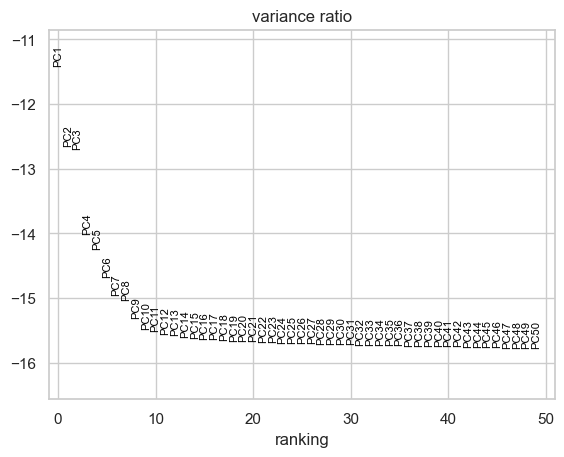

In [43]:
with plt.rc_context():
    sc.pl.pca_variance_ratio(sc_commonDiffFeatures_adata, n_pcs=50, log=True, show=False)
    plt.savefig(figures_dir + "/pca_variance_ratio.pdf", bbox_inches="tight")

In [44]:
sc.pp.neighbors(sc_commonDiffFeatures_adata, n_pcs = 50, n_neighbors = 30, random_state=0)


Text(34.875, 0.5, 'num_feature_per_cell')

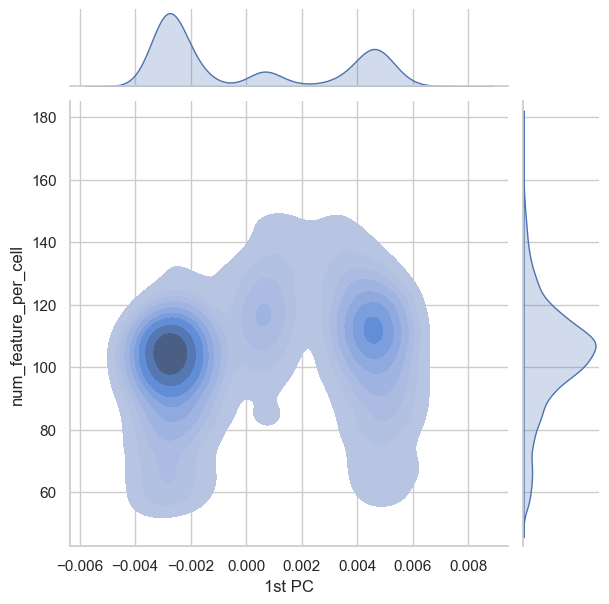

In [45]:
seqDepth_PC1_plot = sns.jointplot(
    x=sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    y=np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']),
    kind="kde",fill=True, 
)
plt.xlabel("1st PC")
plt.ylabel("num_feature_per_cell")


In [46]:
## correlation
np.corrcoef(sc_commonDiffFeatures_adata.obsm['X_pca'][:,0],
    np.sqrt(sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']))

array([[1.        , 0.19563098],
       [0.19563098, 1.        ]])

### 11 -  apply UMAP & leiden clustering

In [47]:
sc.tl.umap(sc_commonDiffFeatures_adata, random_state=0)

In [48]:
sc.tl.leiden(sc_commonDiffFeatures_adata, resolution=leiden_resolution,key_added=leiden_key, random_state=0)

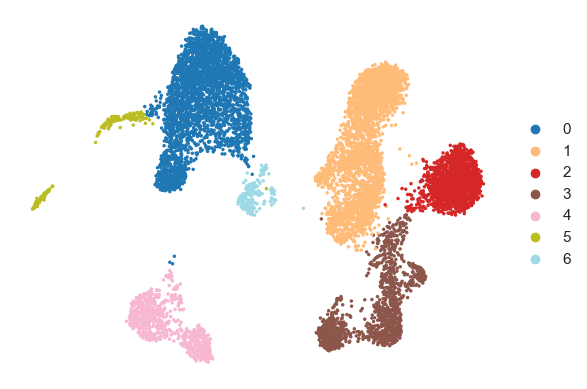

In [49]:
with plt.rc_context():
    sc.pl.umap(sc_commonDiffFeatures_adata, color=leiden_key, show=False,size=25 , add_outline=False, frameon=False, title="",palette="tab20")
    plt.savefig(figures_dir + "/"+ leiden_key+ ".pdf", bbox_inches="tight")

#### loook at sequencing depth

In [50]:
sc_commonDiffFeatures_adata.obs['num_feature_per_cell_'] = sc_commonDiffFeatures_adata.obsm['num_feature_per_cell']

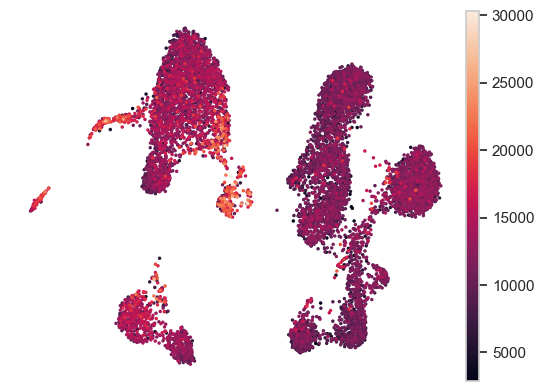

<Figure size 640x480 with 0 Axes>

In [51]:
with plt.rc_context():  
    sc.pl.umap(sc_commonDiffFeatures_adata, color='num_feature_per_cell_', add_outline=False, frameon=False,title ="", save=False, size=25 )
    plt.savefig(figures_dir + "/seq_depth_umap.pdf", bbox_inches="tight")

### 12 - from pseudobulks according to the cluster assignments


In [52]:
cell_cluster_assignments = pd.DataFrame(sc_commonDiffFeatures_adata.obs[leiden_key].copy())
cell_cluster_assignments


,leiden_0.2
cell_IDs,
AAACAGCCAATCCCTT-1,1
AAACAGCCAATGCGCT-1,1
AAACAGCCACCAACCG-1,2
AAACAGCCAGGATAAC-1,1
AAACAGCCAGTTTACG-1,1
...,...
TTTGTTGGTGACATGC-1,2
TTTGTTGGTGTTAAAC-1,2
TTTGTTGGTTAGGATT-1,3


In [53]:
cell_cluster_sizes = pd.DataFrame(cell_cluster_assignments[leiden_key].value_counts())
cell_cluster_sizes['leiden_clusters'] = cell_cluster_sizes.index
cell_cluster_sizes.head()

,count,leiden_clusters
leiden_0.2,,
0,2960,0
1,2830,1
2,1405,2
3,1285,3
4,749,4


In [54]:
for clust_id in set(sc_commonDiffFeatures_adata.obs[leiden_key].values):
    clust_df= sc_commonDiffFeatures_adata[sc_commonDiffFeatures_adata.obs[leiden_key]==clust_id]

In [55]:
cell_types = ([(r.split('_')[0]) for r in clust_df.obs[leiden_key].index])

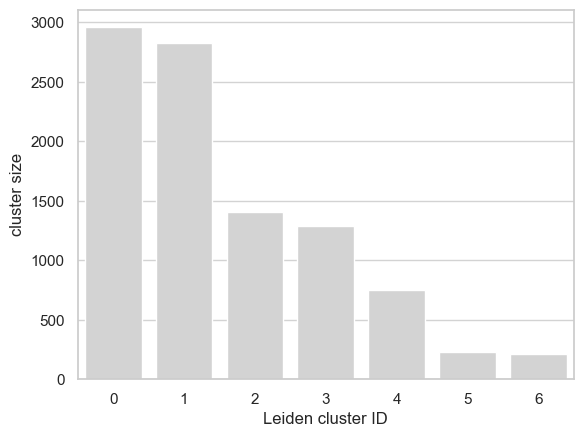

In [56]:
# plot a bar chart
sns.set_style("whitegrid")
ax= sns.barplot(
    y="count", 
    x="leiden_clusters", 
    data=cell_cluster_sizes, 
    color='lightgrey');
ax.yaxis.grid(True,color="lightgrey")
ax.axes.set_xlabel("Leiden cluster ID")
ax.axes.set_ylabel("cluster size")
#atickt(yticks=(list(range(0,1500,100))))
plt.savefig(figures_dir + "/cluster_sizes_"+leiden_key+".pdf", dpi=250)

In [57]:
pseudobulk_commonFeatures_adata = scATAcat.generate_bulk_sparse_AnnData(scATAcat.get_pseudobulk_matrix_ext(adata_to_subset=sc_commonFeatures_adata, adata_to_get_clusters=sc_commonDiffFeatures_adata, cluster_key=leiden_key  ,method = 'sum'))

In [58]:
scATAcat.preprocessing_libsize_norm_log2(pseudobulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 7 × 742116
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [59]:
scATAcat.preprocessing_libsize_norm_log2(bulk_commonFeatures_adata)

AnnData object with n_obs × n_vars = 29 × 742116
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

### 13 - Projection


#### processing 

In [60]:
bulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(bulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [61]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 29 × 19447
    obs: 'cell_types'
    var: 'cCREs'
    layers: 'libsize_norm_log2'

In [62]:
pseudobulk_commonDiffFeatures_adata = scATAcat.subset_adata_vars(pseudobulk_commonFeatures_adata,
                                                 vars_list=common_differential_vars,
                                                 copy_=True)

In [63]:
scATAcat.preprocessing_standardization(bulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=True)

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 29 × 19447
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [64]:
bulk_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 29 × 19447
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_std'

In [65]:
scATAcat.preprocessing_standardization(pseudobulk_commonDiffFeatures_adata, input_layer_key="libsize_norm_log2", zero_center=False,
                              output_layer_key= "libsize_norm_log2_bulk_scaled_diff",
                              std_key= None,  mean_key=None,
                              std_ = bulk_commonDiffFeatures_adata.var["feature_std"],
                              mean_= bulk_commonDiffFeatures_adata.var["feature_mean"])

adding std with default keywords
adding mean with default keywords


AnnData object with n_obs × n_vars = 7 × 19447
    obs: 'cell_types'
    var: 'cCREs', 'feature_std', 'feature_mean'
    layers: 'libsize_norm_log2', 'libsize_norm_log2_bulk_scaled_diff'

In [66]:
## as an option, I can add the color codes from the clustering/ sc adata as a paramater for the pseudobulk matrix 
leiden_color_key = leiden_key+"_colors"
pseudobulk_commonDiffFeatures_adata.uns[leiden_color_key] = sc_commonDiffFeatures_adata.uns[leiden_color_key]

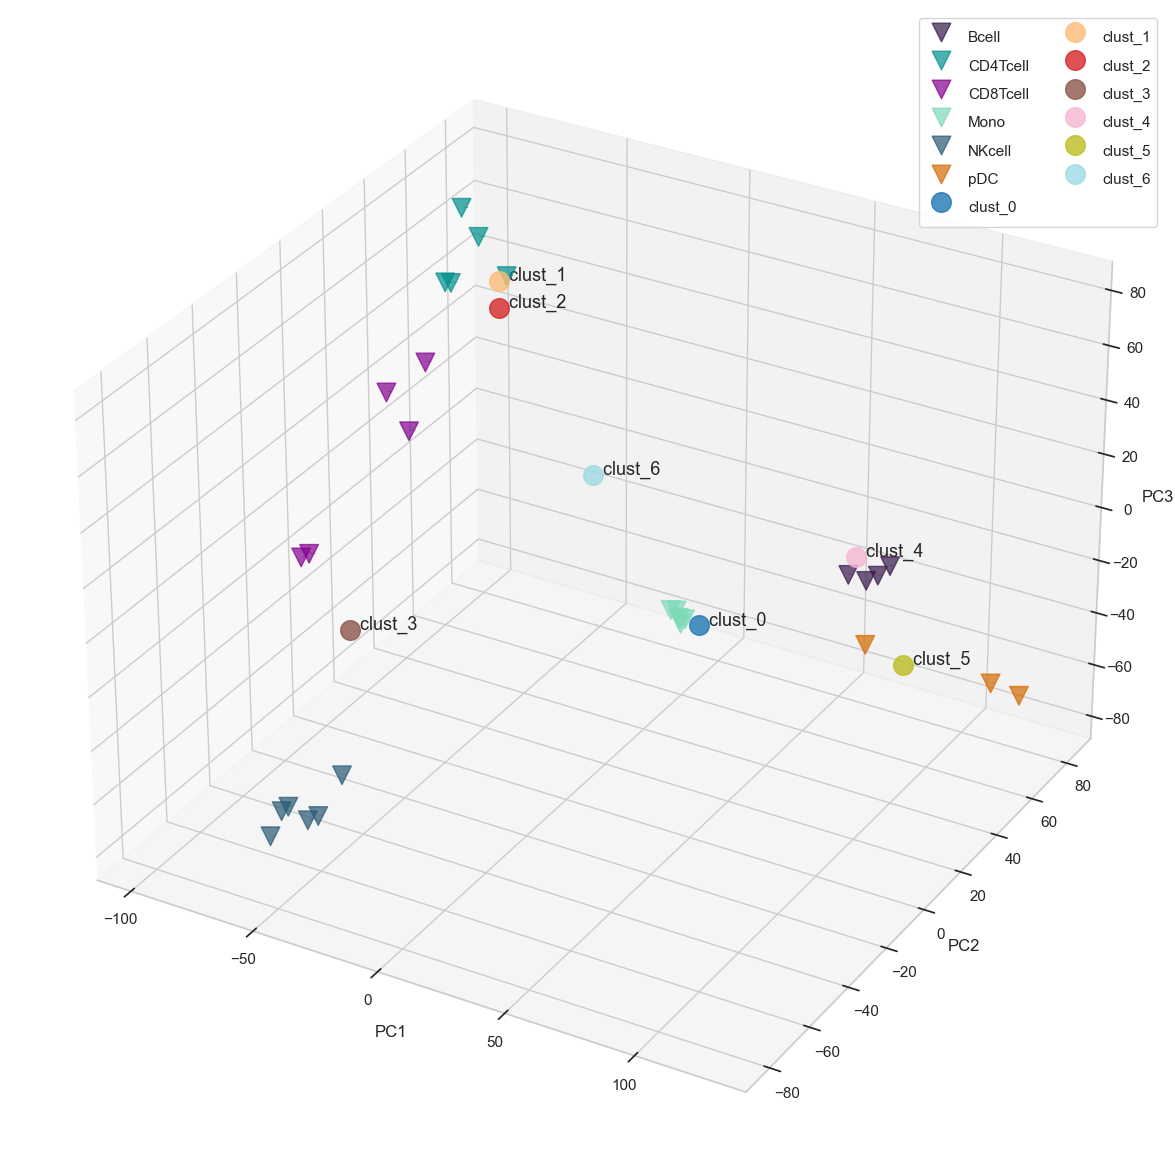

In [67]:
result= scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =13, prototype_label_font_size = 0, 
                            prototype_colors = ['#38184C', "#008F8C", "#82018F",  "#7ED9B7", "#275974", "#D46A00"], pseudobulk_colors =  None, pseudobulk_point_size=200, prototype_point_size=180, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection.png")


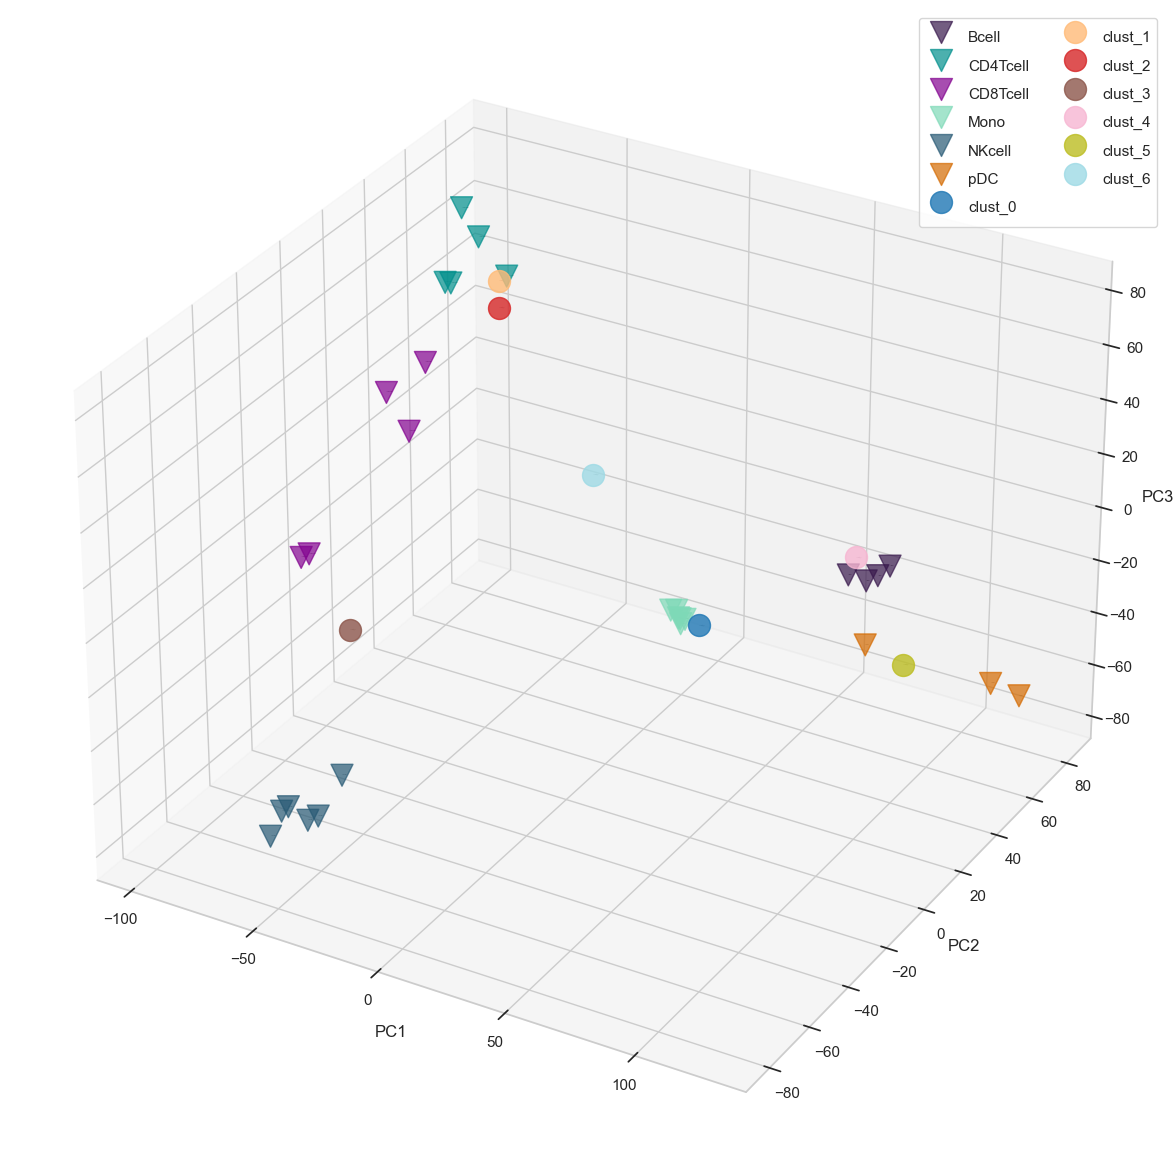

In [68]:
result_noLabel = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C', "#008F8C", "#82018F",  "#7ED9B7", "#275974", "#D46A00"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = True, pseudobulk_legend = True, save_path = figures_dir + "projection_noLabel.png")


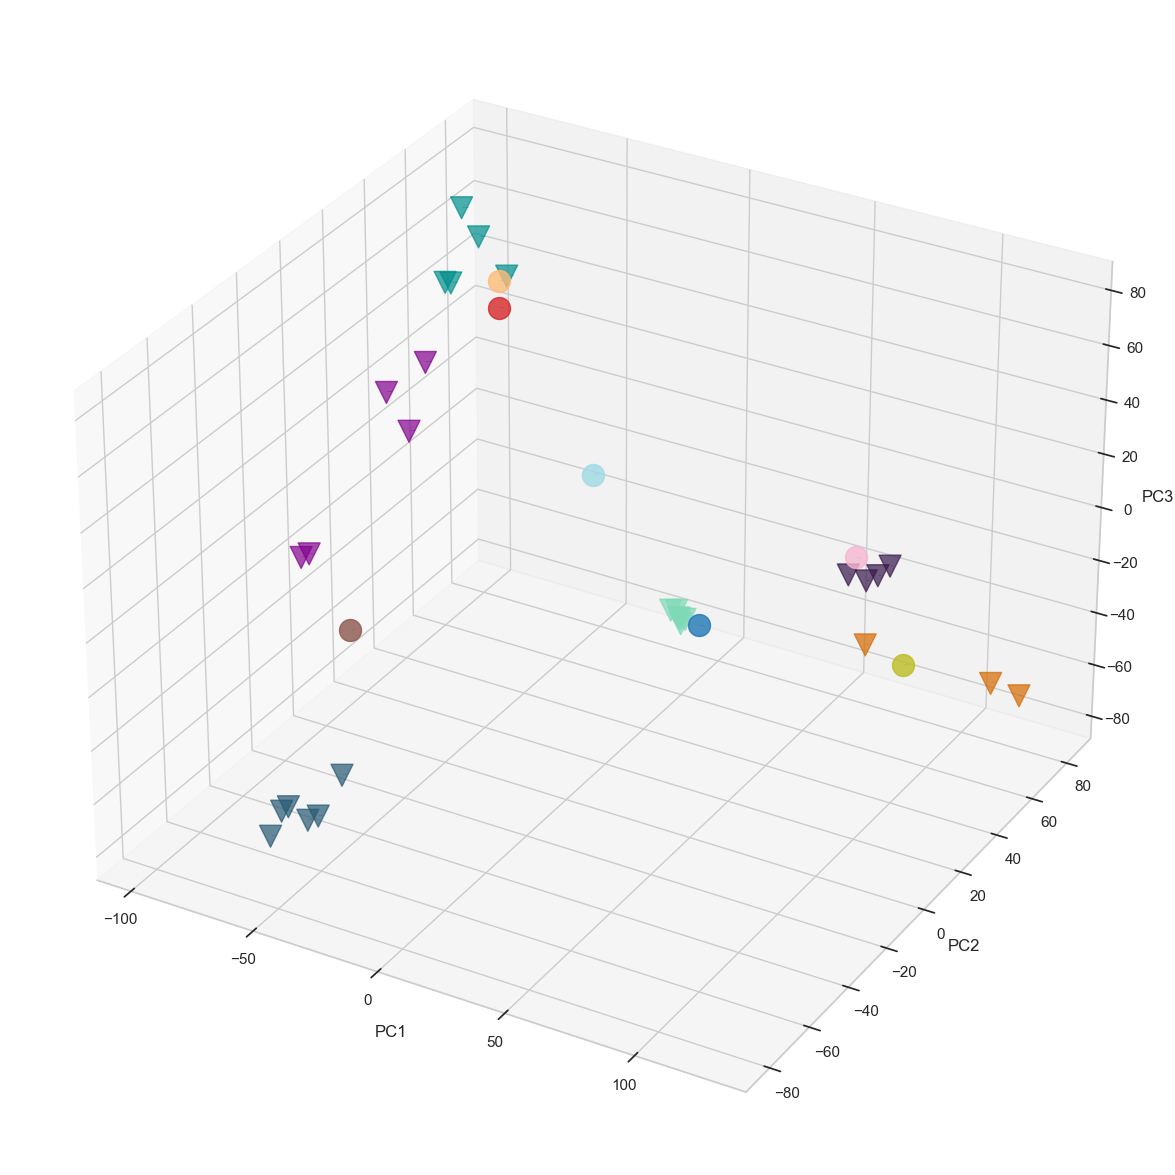

In [69]:
result_noLabel_noLegend = scATAcat.projection(prototype_adata=bulk_commonDiffFeatures_adata, pseudobulk_adata=pseudobulk_commonDiffFeatures_adata, prototype_layer_key = "libsize_norm_log2_std", pseudobulk_layer_key="libsize_norm_log2_bulk_scaled_diff", color_key=leiden_color_key, pseudobulk_label_font_size =0, prototype_label_font_size =0, 
                            prototype_colors = ['#38184C', "#008F8C", "#82018F",  "#7ED9B7", "#275974", "#D46A00"], pseudobulk_colors =  None, pseudobulk_point_size=250, prototype_point_size=250, pseudobulk_point_alpha=0.8, prototype_point_alpha=0.7, cmap='twilight_shifted', prototype_legend = False, pseudobulk_legend = False, save_path = figures_dir + "projection_noLabel_noLegend.png")


### 14 - Assign annotations to clusters


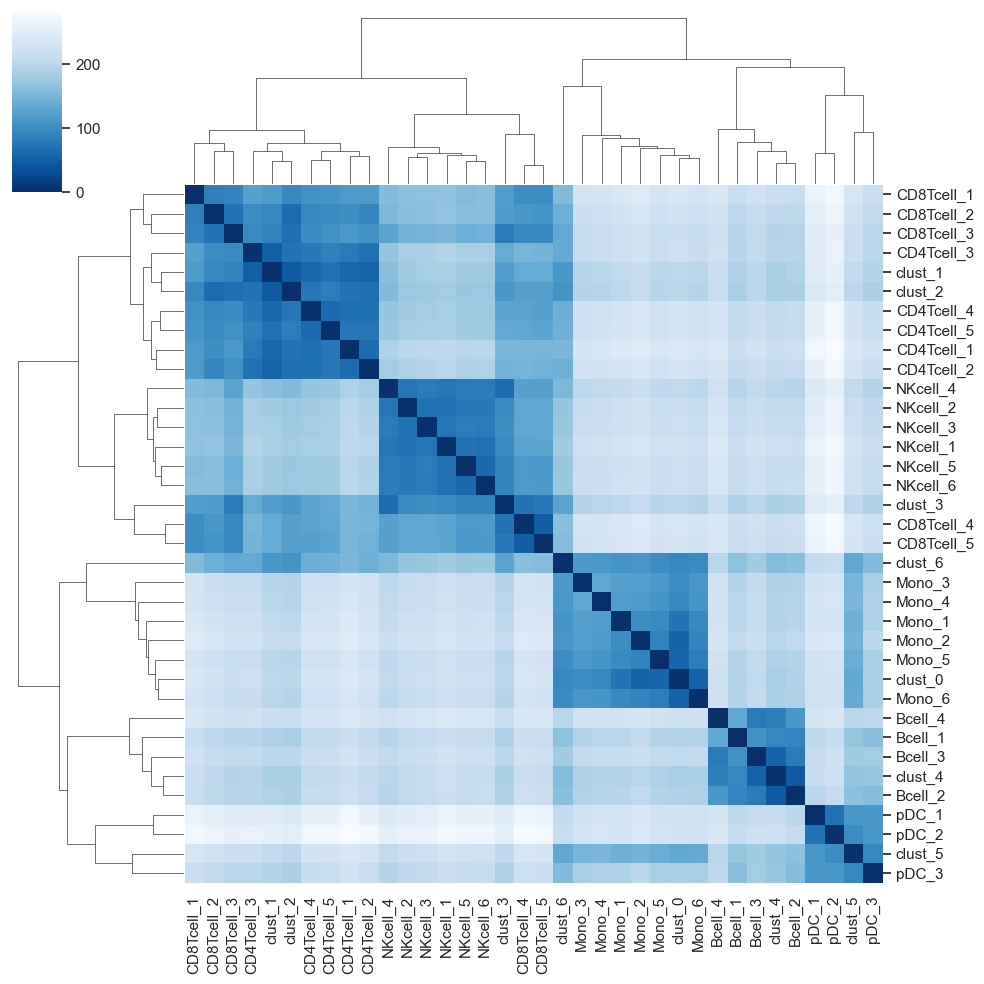

In [70]:
heatmap = scATAcat.plot_pca_dist_heatmap(result[1],result[2])

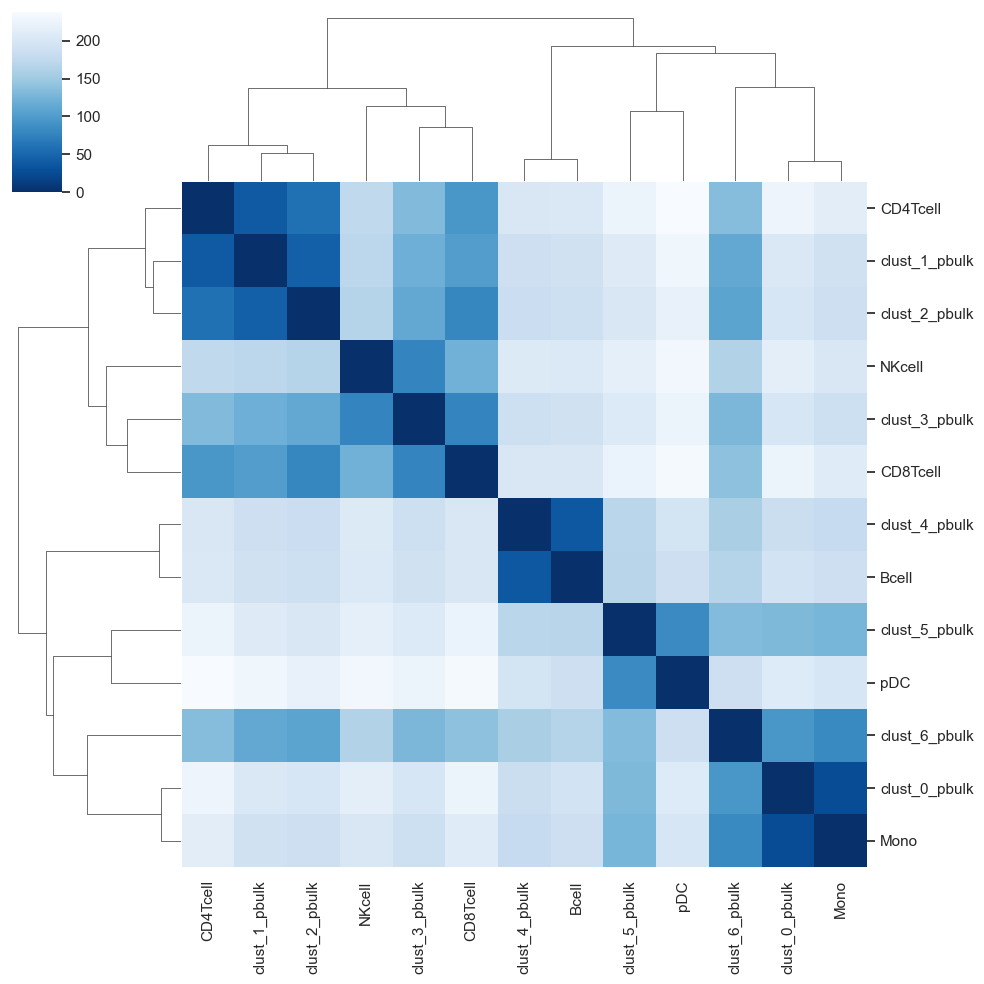

In [71]:
centroid_heatmap =  scATAcat.plot_pca_dist_cent_heatmap(result[1],result[2])


In [72]:
heatmap[0].savefig(figures_dir +"/heatmap.png") 
centroid_heatmap[0].savefig(figures_dir +"/centroid_heatmap.png") 


In [73]:
scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])

{'clust_0_pbulk': 'Mono',
 'clust_1_pbulk': 'CD4Tcell',
 'clust_2_pbulk': 'CD4Tcell',
 'clust_3_pbulk': 'CD8Tcell',
 'clust_4_pbulk': 'Bcell',
 'clust_5_pbulk': 'pDC',
 'clust_6_pbulk': 'Mono'}

In [74]:
clusterID_prediction_dict = scATAcat.get_closest_prototype_to_pseudobulk(centroid_heatmap[1])
clusterID_prediction_dict

{'clust_0_pbulk': 'Mono',
 'clust_1_pbulk': 'CD4Tcell',
 'clust_2_pbulk': 'CD4Tcell',
 'clust_3_pbulk': 'CD8Tcell',
 'clust_4_pbulk': 'Bcell',
 'clust_5_pbulk': 'pDC',
 'clust_6_pbulk': 'Mono'}

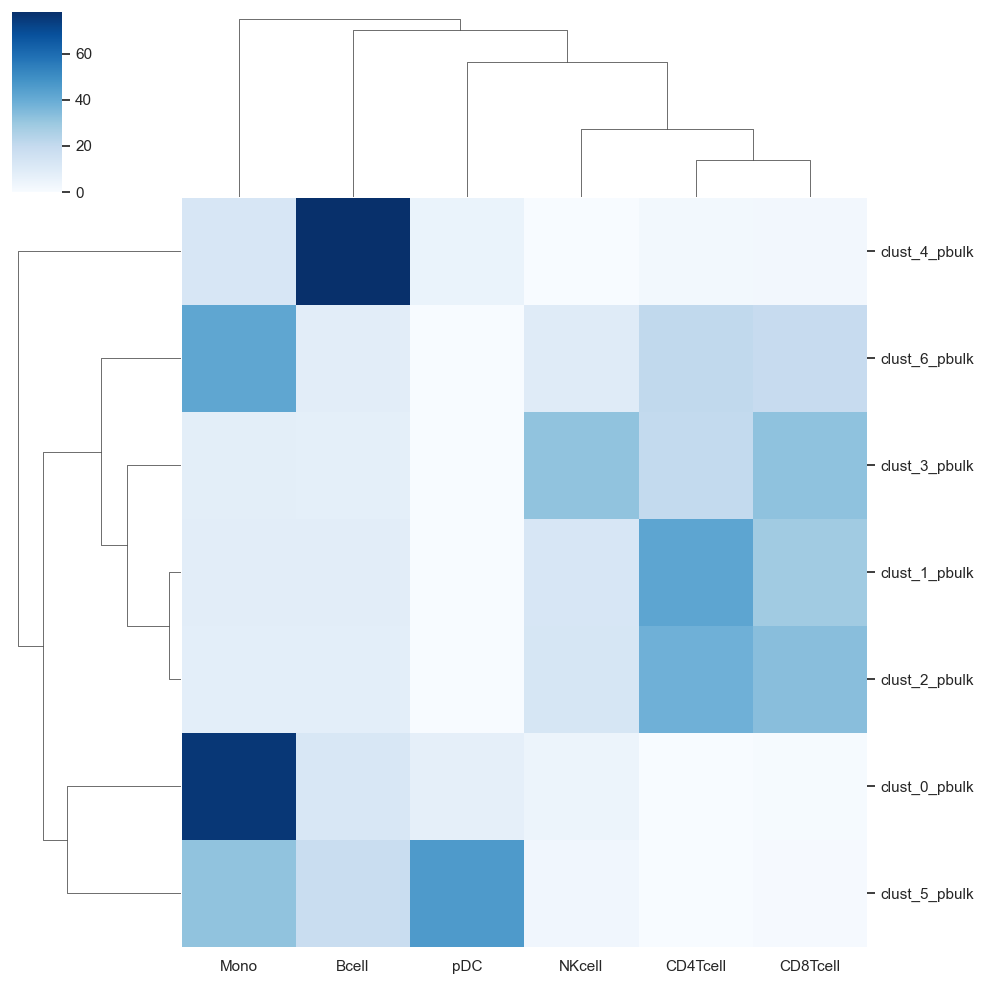

In [75]:
cluster_to_pseudobulk_heatmap_plot = sns.clustermap(scATAcat.get_pseudobulk_to_prototype_distance(centroid_heatmap[1], pbulk_to_prototype=True).T,yticklabels=True,xticklabels=True, cmap="Blues")

In [76]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.png") 


In [77]:
cluster_to_pseudobulk_heatmap_plot.savefig(figures_dir+"/cluster_to_pseudobulk_heatmap_plot.svg") 


### 15- Post hoc analysis

In [78]:
cell_cluster_assignments_with_predictions = copy.deepcopy(cell_cluster_assignments)

#### match the clusterID with predicted cell type

In [79]:
# convert the cell id column to character 
cell_cluster_assignments_with_predictions[leiden_key] = cell_cluster_assignments_with_predictions[leiden_key].astype(str)

In [80]:
cell_cluster_assignments_with_predictions.head()

,leiden_0.2
cell_IDs,
AAACAGCCAATCCCTT-1,1
AAACAGCCAATGCGCT-1,1
AAACAGCCACCAACCG-1,2
AAACAGCCAGGATAAC-1,1
AAACAGCCAGTTTACG-1,1


In [81]:
# refortmat the dict suct that it mactes the clust ID col
clusterID_prediction_dict_edited = dict((''.join(filter(str.isdigit, key)), value) for (key, value) in clusterID_prediction_dict.items())
clusterID_prediction_dict_edited

{'0': 'Mono',
 '1': 'CD4Tcell',
 '2': 'CD4Tcell',
 '3': 'CD8Tcell',
 '4': 'Bcell',
 '5': 'pDC',
 '6': 'Mono'}

In [82]:
cell_cluster_assignments_with_predictions

,leiden_0.2
cell_IDs,
AAACAGCCAATCCCTT-1,1
AAACAGCCAATGCGCT-1,1
AAACAGCCACCAACCG-1,2
AAACAGCCAGGATAAC-1,1
AAACAGCCAGTTTACG-1,1
...,...
TTTGTTGGTGACATGC-1,2
TTTGTTGGTGTTAAAC-1,2
TTTGTTGGTTAGGATT-1,3


In [83]:
cell_cluster_assignments_with_predictions['scATAcat_annotation'] = cell_cluster_assignments_with_predictions[leiden_key].map(clusterID_prediction_dict_edited)

In [84]:
cell_cluster_assignments_with_predictions['cell_IDs'] = cell_cluster_assignments_with_predictions.index

In [85]:
cell_cluster_assignments_with_predictions.to_csv(output_dir +"/scATAcat_annotations_" +leiden_key+ ".csv")

## export AnnData object

In [86]:

with open(output_dir +'/sc_commonDiffFeatures_adata_' +leiden_key+ '.pkl', 'wb') as f:
    pickle.dump(sc_commonDiffFeatures_adata, f)

In [87]:
cell_cluster_assignments.to_csv(output_dir +'cell_cluster_assignments_' +leiden_key+ '.csv')